# Neural Network Models
Using the labelled Lichess data, this notebook will attempt to find a regression neural network which can fit that labelled data.

## Pre-requisites

### If running on Google Collab
If not running on Google collab do not run these next two cells!

In [71]:
"""# Install the only dependency not available from collab directly
!pip install chess

# Get imported files from repo
!git clone -b lichess-neural-networks https://github.com/owenjaques/chessbot.git
!mv chessbot chessbot-repo
!mv chessbot-repo/neural_networks/chessbot .
!rm chessbot-repo -r"""

'# Install the only dependency not available from collab directly\n!pip install chess\n\n# Get imported files from repo\n!git clone -b lichess-neural-networks https://github.com/owenjaques/chessbot.git\n!mv chessbot chessbot-repo\n!mv chessbot-repo/neural_networks/chessbot .\n!rm chessbot-repo -r'

In [72]:
"""from google.colab import drive

drive.mount('/content/gdrive')
working_directory = '/content/gdrive/MyDrive/chessbot_weights/'
data_directory = working_directory"""

"from google.colab import drive\n\ndrive.mount('/content/gdrive')\nworking_directory = '/content/gdrive/MyDrive/chessbot_weights/'\ndata_directory = working_directory"

### If not running on Google Collab
Set the weights directory variable to wherever you would like data saved.

In [73]:
#!mkdir -p bin
working_directory = './bin'
data_directory = '../pre_processing/data'

### Imports

In [74]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import math
import os
import threading
from chessbot import modelinput
from importlib import reload
reload(modelinput)

<module 'chessbot.modelinput' from '/Users/nicholaswurzer/uvic/seng474/project/chessbot/neural_networks/chessbot/modelinput.py'>

### Data generator For Keras

In [75]:
# There is a wierd bug here where more than one worker will cause the input data to get slightly
# messed up, however, using 1 worker seems to be infinitely faster than running this in a loop,
# which is super odd, but I'm not complaining.
def worker(input, output, input_type, start_index, num):
    input_generator = modelinput.ModelInput(input_type)
    
    if input_type == 'all':
        for i in range(num):
            output[0][start_index + i], output[1][start_index + i], output[2][start_index + i] = input_generator.get_input_from_fen(input[start_index + i])
    else:
        for i in range(num):
            output[start_index + i] = input_generator.get_input_from_fen(input[start_index + i])

    print(f'\rThread {start_index // num} completed processing {num} samples.', end='')

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_file, input_type, batch_size=32, pre_process=True, save_file=None, workers=1):
        self.batch_size = batch_size
        data = np.load(data_file, allow_pickle=True)
        self.y = data['y']
        self.n = len(self.y)
        self.input_type = input_type

        if pre_process:
            input_size = modelinput.ModelInput(input_type).input_length()
            
            if input_type == 'all':
                self.X = []
                self.X.append(np.full((self.n, int(input_size[0])), -1.0))
                self.X.append(np.full((self.n, int(input_size[1])), -1.0))
                self.X.append(np.full((self.n, int(input_size[2])), -1.0))
            elif input_type == 'matrix':
                #need size to be 8,8,64
                self.X = np.full((self.n, input_size[0], input_size[1], input_size[2]), -1.0)
            else:
                self.X = np.full((self.n, input_size), -1.0)

            step = self.n // workers

            threads = []
            for i in range(0, self.n, step):
                threads.append(threading.Thread(target=worker, args=(data['X'], self.X, input_type, i, step)))
                threads[-1].start()

            for i in range(workers):
                threads[i].join()
            
            if save_file != None:
                np.savez_compressed(save_file, X=self.X, y=self.y)
        else:
            self.X = data['X']

    def __len__(self):
        return math.ceil(self.n / self.batch_size)

    def __getitem__(self, idx):
        # Returns one batch of data
        low = idx * self.batch_size
        high = np.minimum(low + self.batch_size, self.n)
        
        if self.input_type == 'all':
            return [self.X[0][low:high], self.X[1][low:high], self.X[2][low:high]], self.y[low:high]
        
        return self.X[low:high], self.y[low:high]

## Setting up the Models

### Model with one input
This model will test the performance given just the existence and locations of pieces.

#### Pre-process the data

In [76]:
single_input_training_data = DataGenerator(data_directory + '/training_set.npz', 'positions')
single_input_validation_data = DataGenerator(data_directory + '/validation_set.npz', 'positions')

Thread 0 completed processing 12500 samples..

##### Sanity check
Here we check that the training data was transformed correctly. X and y should both be in the range [0, 1], with exception to -1 for pieces that don't exist.

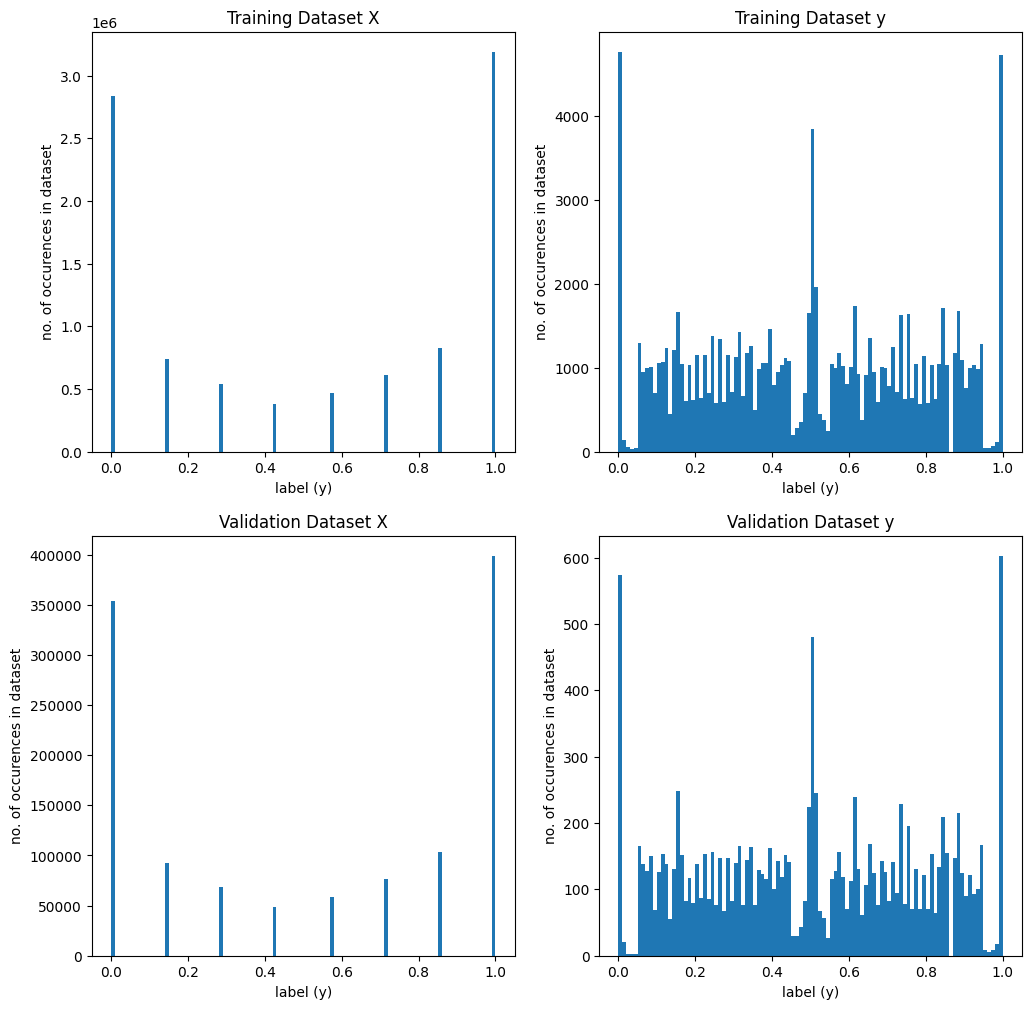

In [77]:
def sanity_check_single_input(training_data, validation_data):
    _, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    ax[0, 0].hist(training_data.X.flatten(), bins=100)
    ax[0, 0].set_title(f'Training Dataset X')
    ax[0, 0].set_xlabel('label (y)')
    ax[0, 0].set_ylabel('no. of occurences in dataset')

    ax[0, 1].hist(training_data.y, bins=100)
    ax[0, 1].set_title(f'Training Dataset y')
    ax[0, 1].set_xlabel('label (y)')
    ax[0, 1].set_ylabel('no. of occurences in dataset')

    ax[1, 0].hist(validation_data.X.flatten(), bins=100)
    ax[1, 0].set_title(f'Validation Dataset X')
    ax[1, 0].set_xlabel('label (y)')
    ax[1, 0].set_ylabel('no. of occurences in dataset')

    ax[1, 1].hist(validation_data.y, bins=100)
    ax[1, 1].set_title(f'Validation Dataset y')
    ax[1, 1].set_xlabel('label (y)')
    ax[1, 1].set_ylabel('no. of occurences in dataset')

    plt.show()

sanity_check_single_input(single_input_training_data, single_input_validation_data)

##### Reduce the number of samples that are ~50% to further balance the dataset

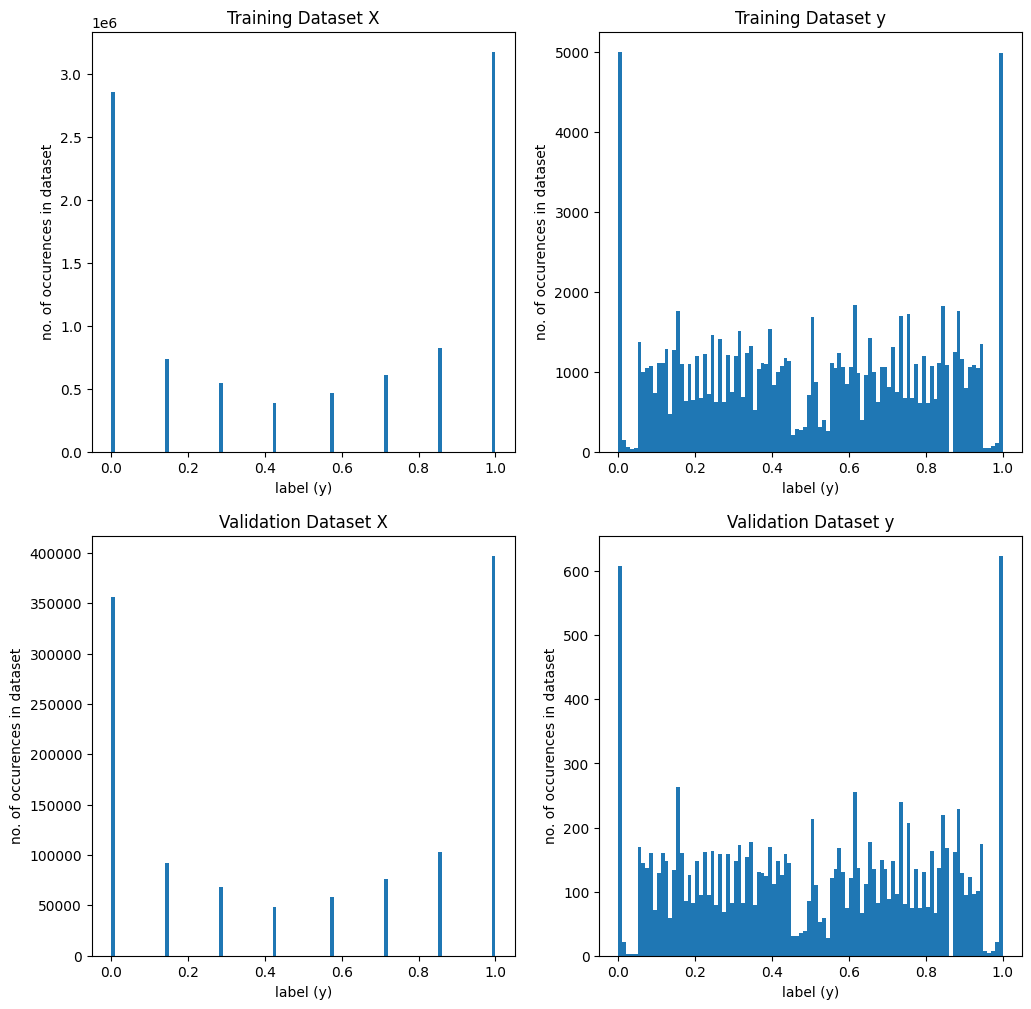

In [78]:
for i in range(single_input_training_data.n):
    if 0.475 < single_input_training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * single_input_training_data.n))
            single_input_training_data.y[i] = single_input_training_data.y[index]
            single_input_training_data.X[i] = single_input_training_data.X[index]

for i in range(single_input_validation_data.n):
    if 0.475 < single_input_validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * single_input_validation_data.n))
            single_input_validation_data.y[i] = single_input_validation_data.y[index]
            single_input_validation_data.X[i] = single_input_validation_data.X[index]

sanity_check_single_input(single_input_training_data, single_input_validation_data)

#### Network Architecture

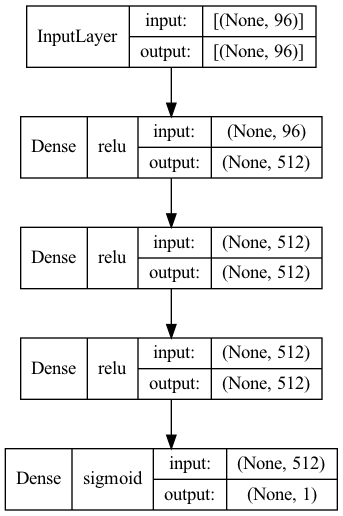

In [79]:
single_input_model = keras.Sequential([
	keras.layers.Input(modelinput.ModelInput('positions').input_length()),
	keras.layers.Dense(512, activation='relu'),
	keras.layers.Dense(512, activation='relu'),
	keras.layers.Dense(512, activation='relu'),
	keras.layers.Dense(1, activation='sigmoid')
])

single_input_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

keras.utils.plot_model(single_input_model, show_shapes=True, show_layer_activations=True, to_file='single_input_model.png', show_layer_names=False)

### Model with three inputs
This will test a model with three different inputs, whose network is based on the network from the Giraffe Chess engine (accessible https://arxiv.org/abs/1509.01549).

#### Pre-process the Data

In [80]:
triple_input_training_data = DataGenerator(data_directory + '/training_set.npz', 'all')
triple_input_validation_data = DataGenerator(data_directory + '/validation_set.npz', 'all')

Thread 0 completed processing 12500 samples..

##### Sanity Check
Like the above model we will check that the dataset has been correctly processed and is in the range [0, 1] (with exception to the positions of pieces that don't exist).

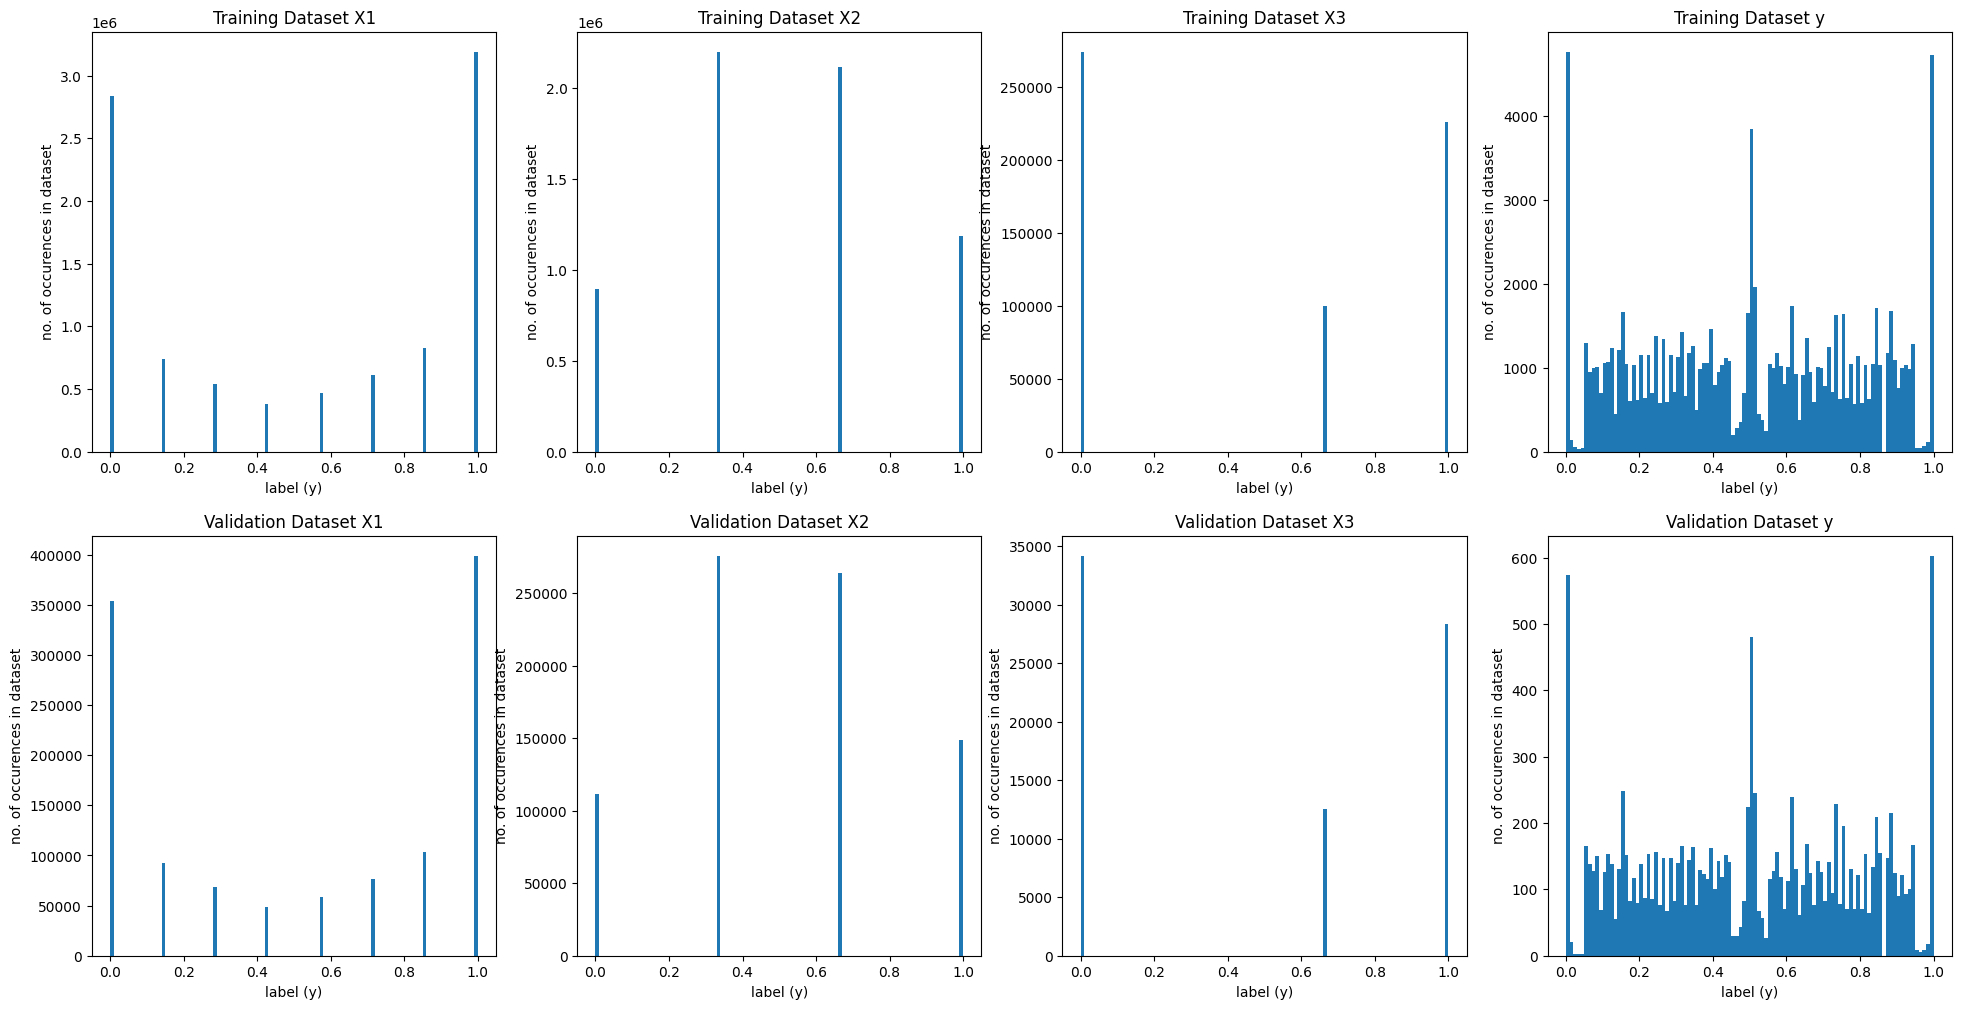

In [81]:
def sanity_check_triple_input(training_data, validation_data):
    _, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))

    ax[0, 0].hist(training_data.X[0].flatten(), bins=100)
    ax[0, 0].set_title(f'Training Dataset X1')
    ax[0, 0].set_xlabel('label (y)')
    ax[0, 0].set_ylabel('no. of occurences in dataset')

    ax[0, 1].hist(training_data.X[1].flatten(), bins=100)
    ax[0, 1].set_title(f'Training Dataset X2')
    ax[0, 1].set_xlabel('label (y)')
    ax[0, 1].set_ylabel('no. of occurences in dataset')

    ax[0, 2].hist(training_data.X[2].flatten(), bins=100)
    ax[0, 2].set_title(f'Training Dataset X3')
    ax[0, 2].set_xlabel('label (y)')
    ax[0, 2].set_ylabel('no. of occurences in dataset')

    ax[0, 3].hist(training_data.y, bins=100)
    ax[0, 3].set_title(f'Training Dataset y')
    ax[0, 3].set_xlabel('label (y)')
    ax[0, 3].set_ylabel('no. of occurences in dataset')

    ax[1, 0].hist(validation_data.X[0].flatten(), bins=100)
    ax[1, 0].set_title(f'Validation Dataset X1')
    ax[1, 0].set_xlabel('label (y)')
    ax[1, 0].set_ylabel('no. of occurences in dataset')

    ax[1, 1].hist(validation_data.X[1].flatten(), bins=100)
    ax[1, 1].set_title(f'Validation Dataset X2')
    ax[1, 1].set_xlabel('label (y)')
    ax[1, 1].set_ylabel('no. of occurences in dataset')

    ax[1, 2].hist(validation_data.X[2].flatten(), bins=100)
    ax[1, 2].set_title(f'Validation Dataset X3')
    ax[1, 2].set_xlabel('label (y)')
    ax[1, 2].set_ylabel('no. of occurences in dataset')

    ax[1, 3].hist(validation_data.y, bins=100)
    ax[1, 3].set_title(f'Validation Dataset y')
    ax[1, 3].set_xlabel('label (y)')
    ax[1, 3].set_ylabel('no. of occurences in dataset')

    plt.show()

sanity_check_triple_input(triple_input_training_data, triple_input_validation_data)

##### Reduce the number of samples that are ~50% to further balance the dataset



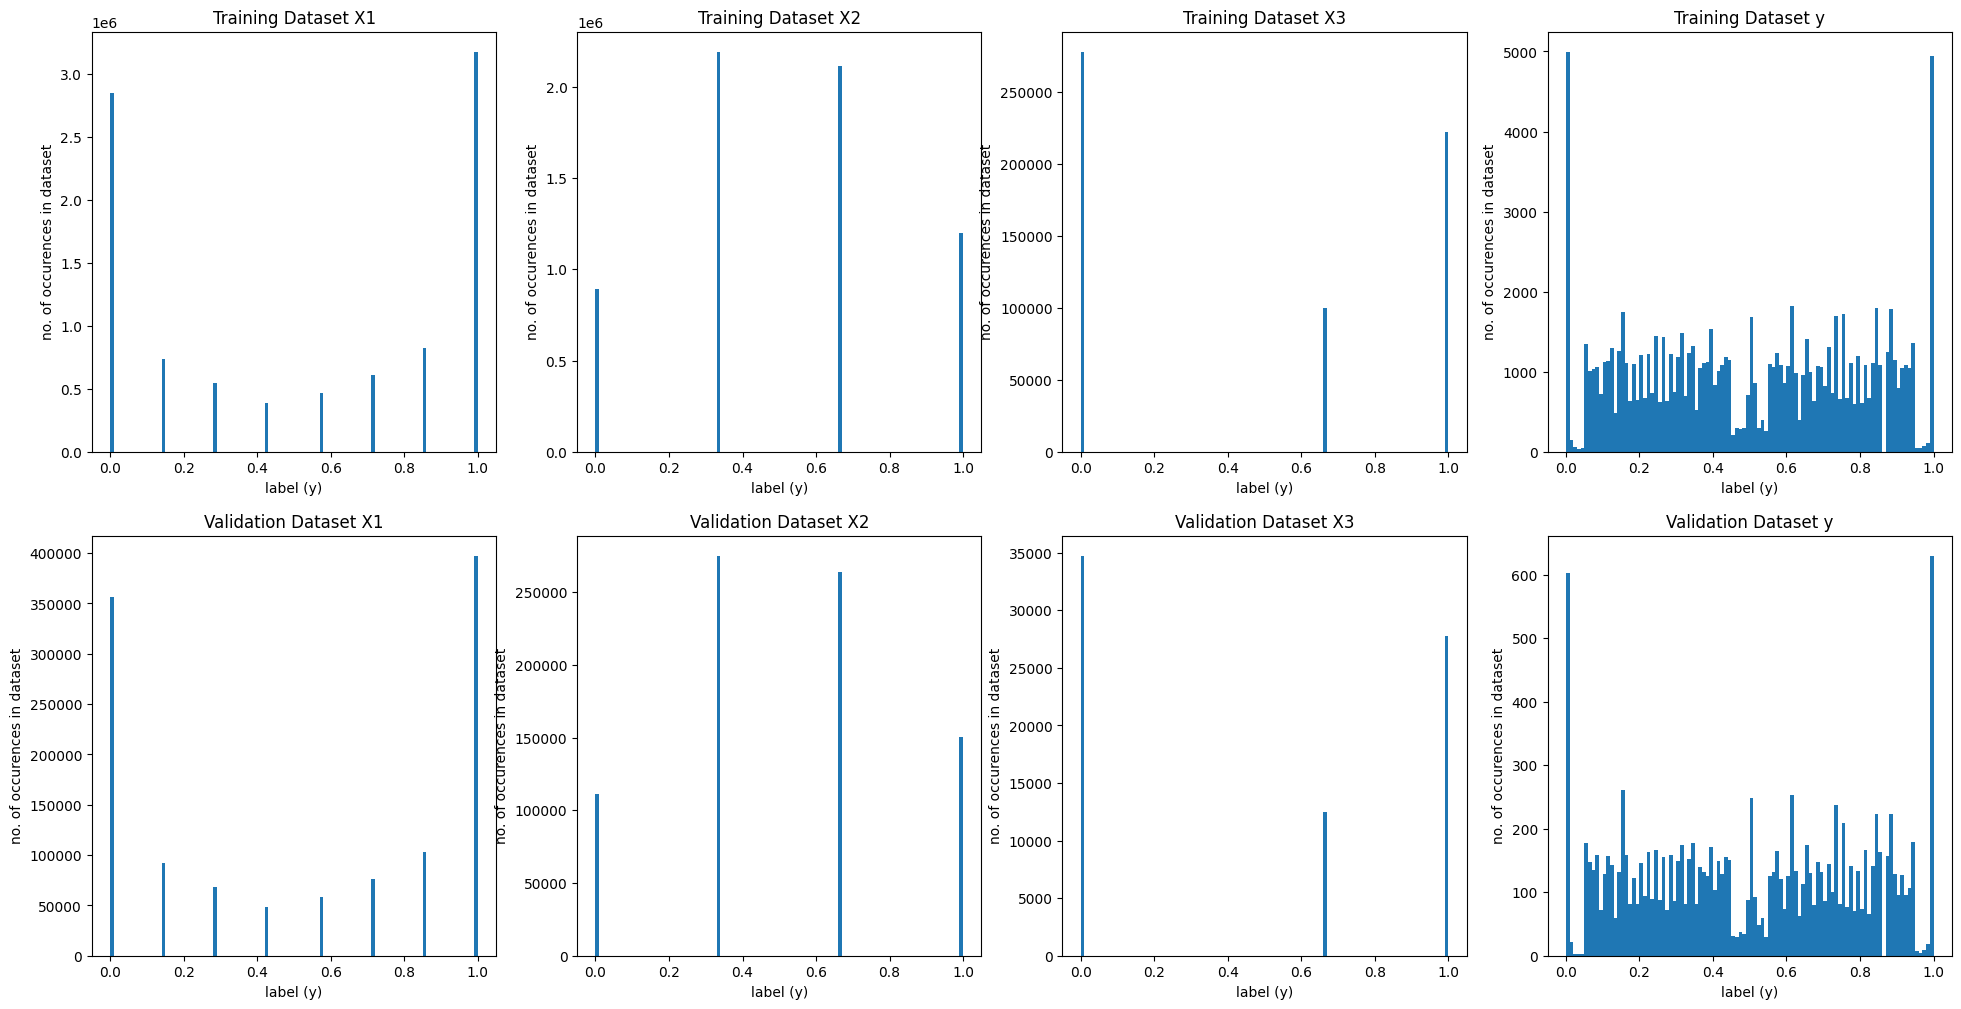

In [82]:
for i in range(triple_input_training_data.n):
    if 0.475 < triple_input_training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * triple_input_training_data.n))
            triple_input_training_data.y[i] = triple_input_training_data.y[index]
            triple_input_training_data.X[0][i] = triple_input_training_data.X[0][index]
            triple_input_training_data.X[1][i] = triple_input_training_data.X[1][index]
            triple_input_training_data.X[2][i] = triple_input_training_data.X[2][index]

for i in range(triple_input_validation_data.n):
    if 0.475 < triple_input_validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * triple_input_validation_data.n))
            triple_input_validation_data.y[i] = triple_input_validation_data.y[index]
            triple_input_validation_data.X[0][i] = triple_input_validation_data.X[0][index]
            triple_input_validation_data.X[1][i] = triple_input_validation_data.X[1][index]
            triple_input_validation_data.X[2][i] = triple_input_validation_data.X[2][index]

sanity_check_triple_input(triple_input_training_data, triple_input_validation_data)

#### Network Architecture

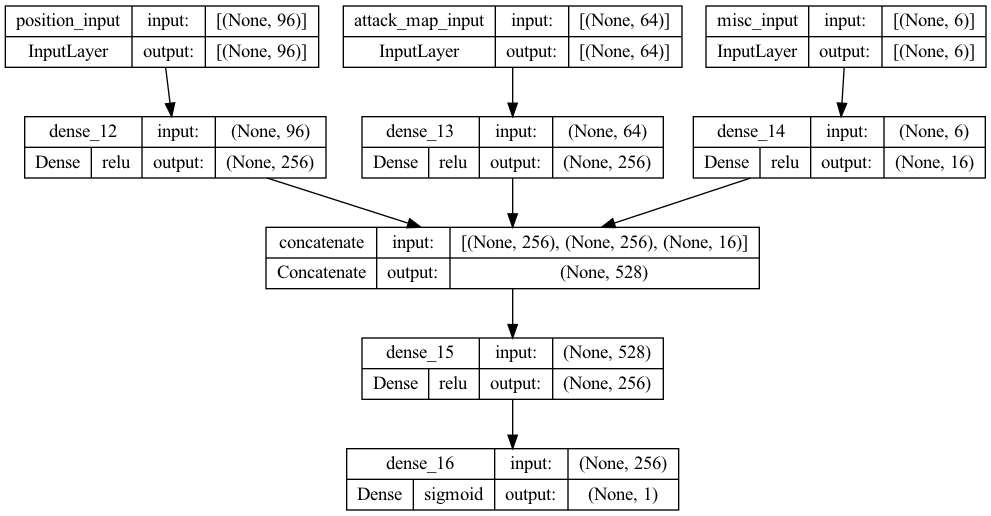

In [83]:
input_shapes = modelinput.ModelInput('all').input_length()

position_input = keras.layers.Input(shape=int(input_shapes[0]), name='position_input')
attacks_input = keras.layers.Input(shape=int(input_shapes[1]), name='attack_map_input')
misc_inputs = keras.layers.Input(shape=int(input_shapes[2]), name='misc_input')

position_dense = keras.layers.Dense(256, activation='relu')(position_input)
attacks_dense = keras.layers.Dense(256, activation='relu')(attacks_input)
misc_dense = keras.layers.Dense(16, activation='relu')(misc_inputs)
x = keras.layers.Concatenate()([position_dense, attacks_dense, misc_dense])
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

triple_input_model = keras.models.Model(inputs=[position_input, attacks_input, misc_inputs], outputs=x)

triple_input_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

keras.utils.plot_model(triple_input_model, show_shapes=True, show_layer_activations=True, to_file='triple_input_model.png')

### Simple Model Input
This will test a model trained on a 'naive' model input where 1 represents the existence of a certain type of piece in a certain position and 0 represents that that piece is not there. This input has 768 features (8 x 8 board with 12 different types of pieces).

#### Pre-process the data

In [84]:
simple_input_training_data = DataGenerator(data_directory + '/training_set.npz', 'simple')
simple_input_validation_data = DataGenerator(data_directory + '/validation_set.npz', 'simple')

Thread 0 completed processing 12500 samples..

##### Sanity Check

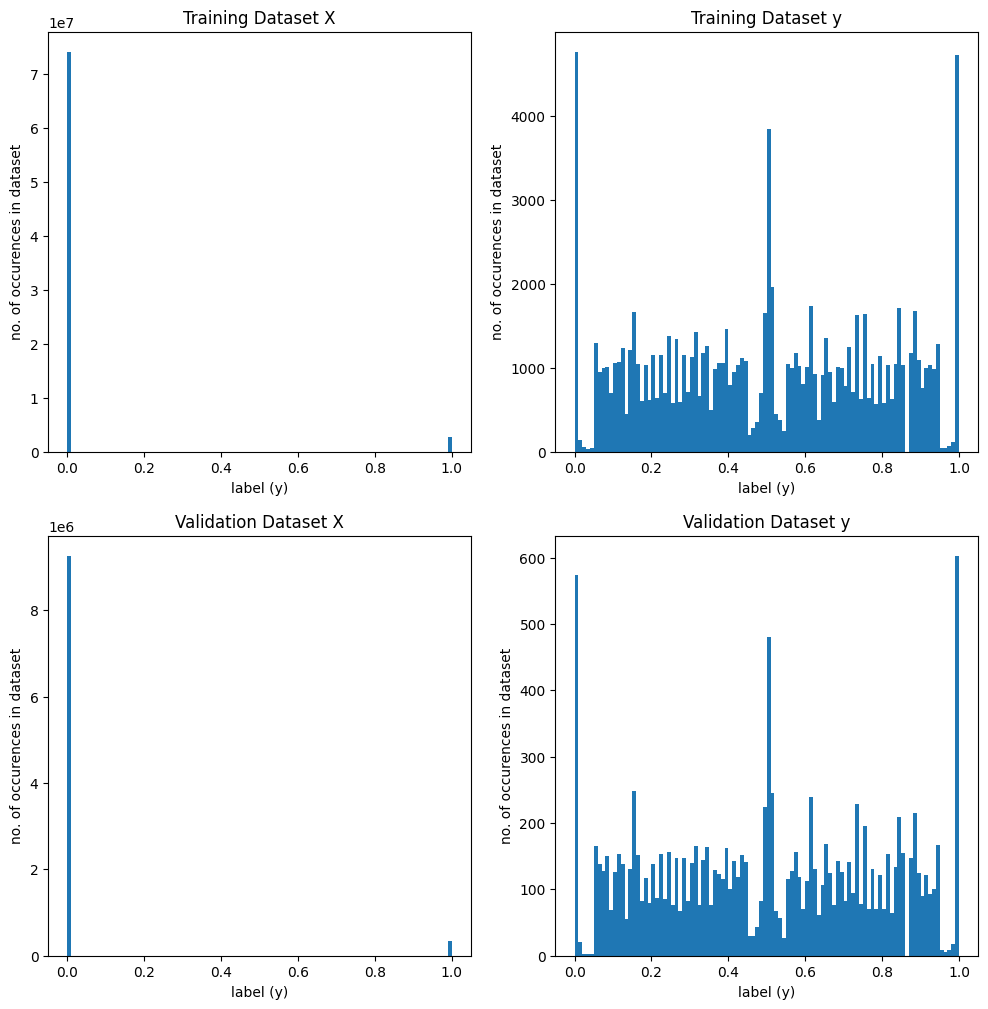

In [85]:
sanity_check_single_input(simple_input_training_data, simple_input_validation_data)

##### Once again reduce 50% bin

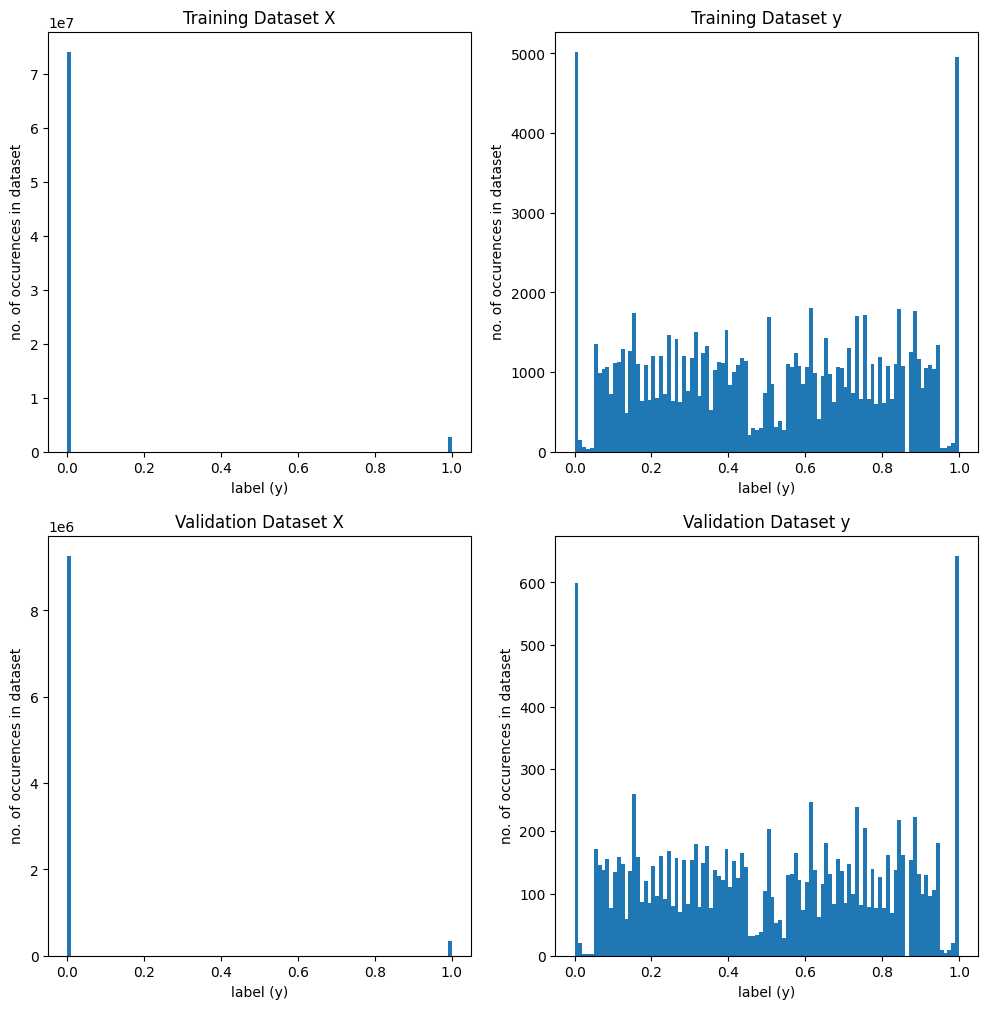

In [86]:
for i in range(simple_input_training_data.n):
    if 0.475 < simple_input_training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * simple_input_training_data.n))
            simple_input_training_data.y[i] = simple_input_training_data.y[index]
            simple_input_training_data.X[i] = simple_input_training_data.X[index]

for i in range(simple_input_validation_data.n):
    if 0.475 < simple_input_validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * simple_input_validation_data.n))
            simple_input_validation_data.y[i] = simple_input_validation_data.y[index]
            simple_input_validation_data.X[i] = simple_input_validation_data.X[index]

sanity_check_single_input(simple_input_training_data, simple_input_validation_data)

#### Network Architecture

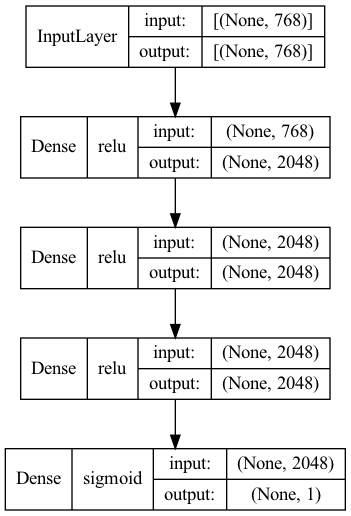

In [87]:
simple_input_model = keras.Sequential([
	keras.layers.Input(modelinput.ModelInput('simple').input_length()),
	keras.layers.Dense(2048, activation='relu'),
	keras.layers.Dense(2048, activation='relu'),
	keras.layers.Dense(2048, activation='relu'),
	keras.layers.Dense(1, activation='sigmoid')
])

simple_input_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

keras.utils.plot_model(simple_input_model, show_shapes=True, show_layer_activations=True, to_file='simple_input_model.png', show_layer_names=False)

### Convolutional Neural Network Input

#### Preprocess Data

In [88]:
matrix_input_training_data = DataGenerator(data_directory + '/training_set.npz', 'matrix')
matrix_input_validation_data = DataGenerator(data_directory + '/validation_set.npz', 'matrix')

Thread 0 completed processing 12500 samples..

#### Sanity Check

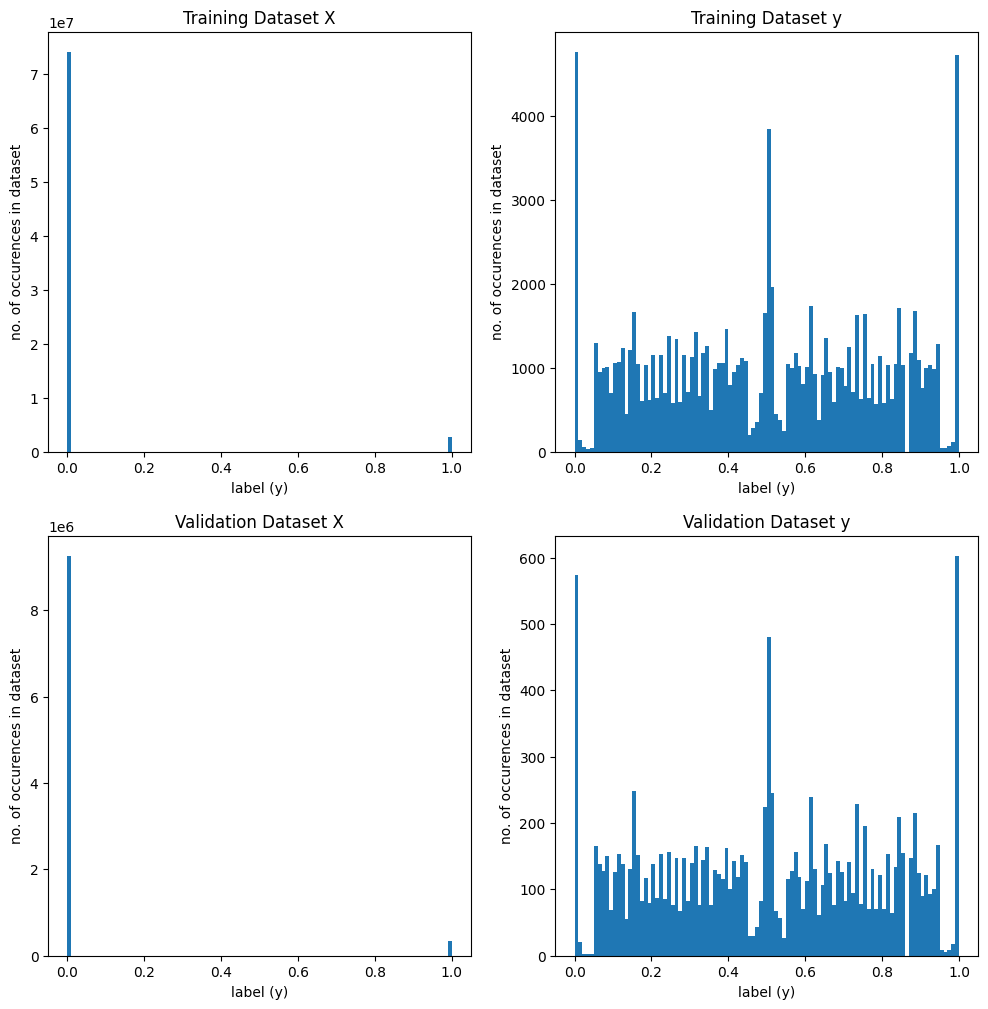

In [89]:
sanity_check_single_input(matrix_input_training_data, matrix_input_validation_data)

#### Reduce 50% Bins

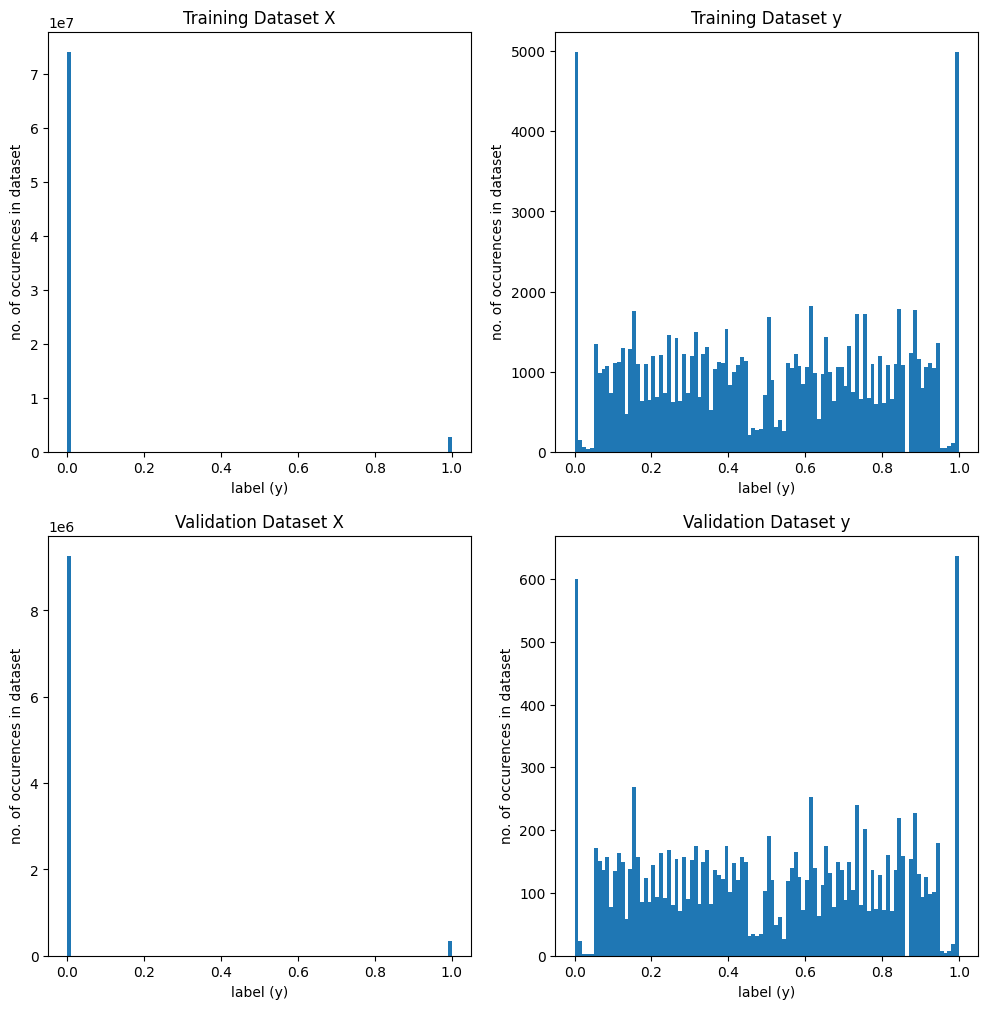

In [90]:
for i in range(matrix_input_training_data.n):
    if 0.475 < matrix_input_training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * matrix_input_training_data.n))
            matrix_input_training_data.y[i] = matrix_input_training_data.y[index]
            matrix_input_training_data.X[i] = matrix_input_training_data.X[index]

for i in range(matrix_input_validation_data.n):
    if 0.475 < matrix_input_validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * matrix_input_validation_data.n))
            matrix_input_validation_data.y[i] = matrix_input_validation_data.y[index]
            matrix_input_validation_data.X[i] = matrix_input_validation_data.X[index]

sanity_check_single_input(matrix_input_training_data, matrix_input_validation_data)

#### Network Architecture

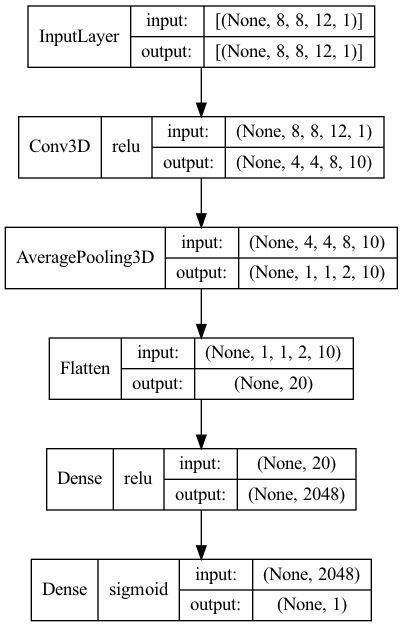

In [91]:
"""matrix_input_model = keras.Sequential([
	keras.layers.Input(modelinput.ModelInput('simple').input_length()),
	keras.layers.Dense(2048, activation='relu'),
	keras.layers.Dense(2048, activation='relu'),
	keras.layers.Dense(2048, activation='relu'),
	keras.layers.Dense(1, activation='sigmoid')
])"""
matrix_input_model = keras.Sequential()
matrix_input_model.add(keras.layers.Conv3D(filters = 10, kernel_size = 5, input_shape = (8,8,12,1), activation = 'relu'))
matrix_input_model.add(keras.layers.AveragePooling3D(pool_size = (4,4,4), strides = 3))
matrix_input_model.add(keras.layers.Flatten())
matrix_input_model.add(keras.layers.Dense(units = 2048, activation = 'relu'))
matrix_input_model.add(keras.layers.Dense(1, activation='sigmoid'))

matrix_input_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

keras.utils.plot_model(matrix_input_model, show_shapes=True, show_layer_activations=True, to_file='simple_input_model.png', show_layer_names=False)


## Training the Models

In [92]:
def train_model(model, training_data, validation_data, save_to):
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        restore_best_weights=True,
        patience=5,
        verbose=1)

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=0.000000000001,
        verbose=1)

    checkpoint = keras.callbacks.ModelCheckpoint(
        f'{save_to}/model',
        monitor='val_loss',
        save_best_only=True)

    tensorboard = keras.callbacks.TensorBoard(
        log_dir=f'{save_to}/logs',
        write_graph=True,
        write_images=True,
        histogram_freq=1)

    model.fit(
        training_data,
        epochs=128,
        validation_data=validation_data,
        callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard])

### Training the single input model

In [93]:
save_to = f'{data_directory}/single_input_model'
if not os.path.exists(save_to):
    os.makedirs(save_to)

train_model(single_input_model, single_input_training_data, single_input_validation_data, save_to)

Epoch 1/128


2023-03-30 19:14:23.001430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3125/3125 [==============================] - ETA: 0s - loss: 0.0773 - mean_absolute_error: 0.2332

2023-03-30 19:14:56.170025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 36s 11ms/step - loss: 0.0773 - mean_absolute_error: 0.2332 - val_loss: 0.0739 - val_mean_absolute_error: 0.2259 - lr: 0.0010
Epoch 2/128
3122/3125 [============================>.] - ETA: 0s - loss: 0.0718 - mean_absolute_error: 0.2210

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 34s 11ms/step - loss: 0.0718 - mean_absolute_error: 0.2210 - val_loss: 0.0714 - val_mean_absolute_error: 0.2200 - lr: 0.0010
Epoch 3/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.2149

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 33s 10ms/step - loss: 0.0689 - mean_absolute_error: 0.2149 - val_loss: 0.0691 - val_mean_absolute_error: 0.2141 - lr: 0.0010
Epoch 4/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0666 - mean_absolute_error: 0.2101
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0666 - mean_absolute_error: 0.2101 - val_loss: 0.0698 - val_mean_absolute_error: 0.2136 - lr: 0.0010
Epoch 5/128
3124/3125 [============================>.] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1990

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 34s 11ms/step - loss: 0.0615 - mean_absolute_error: 0.1990 - val_loss: 0.0644 - val_mean_absolute_error: 0.2033 - lr: 2.0000e-04
Epoch 6/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0596 - mean_absolute_error: 0.1950

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 33s 10ms/step - loss: 0.0596 - mean_absolute_error: 0.1950 - val_loss: 0.0640 - val_mean_absolute_error: 0.2009 - lr: 2.0000e-04
Epoch 7/128
3121/3125 [============================>.] - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.1919

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 35s 11ms/step - loss: 0.0581 - mean_absolute_error: 0.1919 - val_loss: 0.0639 - val_mean_absolute_error: 0.2015 - lr: 2.0000e-04
Epoch 8/128
3119/3125 [============================>.] - ETA: 0s - loss: 0.0566 - mean_absolute_error: 0.1887

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 29s 9ms/step - loss: 0.0566 - mean_absolute_error: 0.1887 - val_loss: 0.0625 - val_mean_absolute_error: 0.1964 - lr: 2.0000e-04
Epoch 9/128
3121/3125 [============================>.] - ETA: 0s - loss: 0.0552 - mean_absolute_error: 0.1856

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 29s 9ms/step - loss: 0.0552 - mean_absolute_error: 0.1856 - val_loss: 0.0623 - val_mean_absolute_error: 0.1947 - lr: 2.0000e-04
Epoch 10/128
3120/3125 [============================>.] - ETA: 0s - loss: 0.0537 - mean_absolute_error: 0.1824

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 29s 9ms/step - loss: 0.0537 - mean_absolute_error: 0.1824 - val_loss: 0.0612 - val_mean_absolute_error: 0.1939 - lr: 2.0000e-04
Epoch 11/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0523 - mean_absolute_error: 0.1795

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 29s 9ms/step - loss: 0.0523 - mean_absolute_error: 0.1795 - val_loss: 0.0611 - val_mean_absolute_error: 0.1924 - lr: 2.0000e-04
Epoch 12/128
3123/3125 [============================>.] - ETA: 0s - loss: 0.0509 - mean_absolute_error: 0.1764
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
3125/3125 [==============================] - 28s 9ms/step - loss: 0.0509 - mean_absolute_error: 0.1764 - val_loss: 0.0613 - val_mean_absolute_error: 0.1927 - lr: 2.0000e-04
Epoch 13/128
3119/3125 [============================>.] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.1699

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 28s 9ms/step - loss: 0.0478 - mean_absolute_error: 0.1699 - val_loss: 0.0600 - val_mean_absolute_error: 0.1883 - lr: 4.0000e-05
Epoch 14/128
3124/3125 [============================>.] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.1680

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 30s 9ms/step - loss: 0.0471 - mean_absolute_error: 0.1680 - val_loss: 0.0596 - val_mean_absolute_error: 0.1890 - lr: 4.0000e-05
Epoch 15/128
3124/3125 [============================>.] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.1668
Epoch 15: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
3125/3125 [==============================] - 29s 9ms/step - loss: 0.0466 - mean_absolute_error: 0.1668 - val_loss: 0.0597 - val_mean_absolute_error: 0.1878 - lr: 4.0000e-05
Epoch 16/128
3122/3125 [============================>.] - ETA: 0s - loss: 0.0457 - mean_absolute_error: 0.1650

INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 29s 9ms/step - loss: 0.0457 - mean_absolute_error: 0.1650 - val_loss: 0.0594 - val_mean_absolute_error: 0.1877 - lr: 8.0000e-06
Epoch 17/128
3122/3125 [============================>.] - ETA: 0s - loss: 0.0455 - mean_absolute_error: 0.1646
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 29s 9ms/step - loss: 0.0455 - mean_absolute_error: 0.1646 - val_loss: 0.0594 - val_mean_absolute_error: 0.1874 - lr: 8.0000e-06
Epoch 18/128
3119/3125 [============================>.] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.1641
Epoch 18: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/single_input_model/model/assets


3125/3125 [==============================] - 28s 9ms/step - loss: 0.0453 - mean_absolute_error: 0.1641 - val_loss: 0.0593 - val_mean_absolute_error: 0.1874 - lr: 1.6000e-06
Epoch 19/128
3122/3125 [============================>.] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.1641
Epoch 19: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
3125/3125 [==============================] - 29s 9ms/step - loss: 0.0453 - mean_absolute_error: 0.1641 - val_loss: 0.0593 - val_mean_absolute_error: 0.1874 - lr: 3.2000e-07
Epoch 20/128
3121/3125 [============================>.] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.1641
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
3125/3125 [==============================] - 28s 9ms/step - loss: 0.0453 - mean_absolute_error: 0.1641 - val_loss: 0.0593 - val_mean_absolute_error: 0.1874 - lr: 6.4000e-08
Epoch 21/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 

### Training the triple input model

In [94]:
save_to = f'{data_directory}/triple_input_model'
if not os.path.exists(save_to):
    os.makedirs(save_to)

train_model(triple_input_model, triple_input_training_data, triple_input_validation_data, save_to)

Epoch 1/128


2023-03-30 19:26:01.409012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3120/3125 [============================>.] - ETA: 0s - loss: 0.0719 - mean_absolute_error: 0.2204

2023-03-30 19:26:14.155208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 15s 4ms/step - loss: 0.0718 - mean_absolute_error: 0.2204 - val_loss: 0.0684 - val_mean_absolute_error: 0.2140 - lr: 0.0010
Epoch 2/128
3115/3125 [============================>.] - ETA: 0s - loss: 0.0652 - mean_absolute_error: 0.2066

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 13s 4ms/step - loss: 0.0652 - mean_absolute_error: 0.2066 - val_loss: 0.0643 - val_mean_absolute_error: 0.2039 - lr: 0.0010
Epoch 3/128
3112/3125 [============================>.] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1981
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0612 - mean_absolute_error: 0.1980 - val_loss: 0.0668 - val_mean_absolute_error: 0.2080 - lr: 0.0010
Epoch 4/128
3121/3125 [============================>.] - ETA: 0s - loss: 0.0542 - mean_absolute_error: 0.1838

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 13s 4ms/step - loss: 0.0542 - mean_absolute_error: 0.1838 - val_loss: 0.0586 - val_mean_absolute_error: 0.1899 - lr: 2.0000e-04
Epoch 5/128
3117/3125 [============================>.] - ETA: 0s - loss: 0.0518 - mean_absolute_error: 0.1787

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 14s 4ms/step - loss: 0.0518 - mean_absolute_error: 0.1787 - val_loss: 0.0575 - val_mean_absolute_error: 0.1867 - lr: 2.0000e-04
Epoch 6/128
3112/3125 [============================>.] - ETA: 0s - loss: 0.0499 - mean_absolute_error: 0.1747

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 13s 4ms/step - loss: 0.0498 - mean_absolute_error: 0.1747 - val_loss: 0.0570 - val_mean_absolute_error: 0.1852 - lr: 2.0000e-04
Epoch 7/128
3121/3125 [============================>.] - ETA: 0s - loss: 0.0480 - mean_absolute_error: 0.1706

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 14s 4ms/step - loss: 0.0480 - mean_absolute_error: 0.1706 - val_loss: 0.0555 - val_mean_absolute_error: 0.1833 - lr: 2.0000e-04
Epoch 8/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0462 - mean_absolute_error: 0.1670

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 14s 4ms/step - loss: 0.0462 - mean_absolute_error: 0.1670 - val_loss: 0.0549 - val_mean_absolute_error: 0.1812 - lr: 2.0000e-04
Epoch 9/128
3115/3125 [============================>.] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.1633

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 14s 4ms/step - loss: 0.0444 - mean_absolute_error: 0.1633 - val_loss: 0.0538 - val_mean_absolute_error: 0.1782 - lr: 2.0000e-04
Epoch 10/128
3120/3125 [============================>.] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.1596

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 14s 4ms/step - loss: 0.0427 - mean_absolute_error: 0.1596 - val_loss: 0.0533 - val_mean_absolute_error: 0.1772 - lr: 2.0000e-04
Epoch 11/128
3120/3125 [============================>.] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.1562

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 14s 4ms/step - loss: 0.0411 - mean_absolute_error: 0.1562 - val_loss: 0.0527 - val_mean_absolute_error: 0.1748 - lr: 2.0000e-04
Epoch 12/128
3124/3125 [============================>.] - ETA: 0s - loss: 0.0396 - mean_absolute_error: 0.1529
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0396 - mean_absolute_error: 0.1529 - val_loss: 0.0528 - val_mean_absolute_error: 0.1751 - lr: 2.0000e-04
Epoch 13/128
3118/3125 [============================>.] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.1456

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 13s 4ms/step - loss: 0.0363 - mean_absolute_error: 0.1456 - val_loss: 0.0514 - val_mean_absolute_error: 0.1714 - lr: 4.0000e-05
Epoch 14/128
3119/3125 [============================>.] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.1441
Epoch 14: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0357 - mean_absolute_error: 0.1442 - val_loss: 0.0516 - val_mean_absolute_error: 0.1723 - lr: 4.0000e-05
Epoch 15/128
3112/3125 [============================>.] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.1424

INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/triple_input_model/model/assets


3125/3125 [==============================] - 13s 4ms/step - loss: 0.0349 - mean_absolute_error: 0.1424 - val_loss: 0.0511 - val_mean_absolute_error: 0.1708 - lr: 8.0000e-06
Epoch 16/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.1420
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
3125/3125 [==============================] - 12s 4ms/step - loss: 0.0348 - mean_absolute_error: 0.1420 - val_loss: 0.0512 - val_mean_absolute_error: 0.1710 - lr: 8.0000e-06
Epoch 17/128
3113/3125 [============================>.] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.1417
Epoch 17: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0346 - mean_absolute_error: 0.1417 - val_loss: 0.0511 - val_mean_absolute_error: 0.1708 - lr: 1.6000e-06
Epoch 18/128
3123/3125 [============================>.] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 

### Training the simple input model

In [95]:
save_to = f'{data_directory}/simple_input_model'
if not os.path.exists(save_to):
    os.makedirs(save_to)

train_model(simple_input_model, simple_input_training_data, simple_input_validation_data, save_to)

Epoch 1/128


2023-03-30 19:30:26.566937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3125/3125 [==============================] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.2001

2023-03-30 19:36:20.986647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Assets written to: ../pre_processing/data/simple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/simple_input_model/model/assets


3125/3125 [==============================] - 366s 117ms/step - loss: 0.0625 - mean_absolute_error: 0.2001 - val_loss: 0.0513 - val_mean_absolute_error: 0.1753 - lr: 0.0010
Epoch 2/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.1502

INFO:tensorflow:Assets written to: ../pre_processing/data/simple_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/simple_input_model/model/assets


3125/3125 [==============================] - 364s 116ms/step - loss: 0.0398 - mean_absolute_error: 0.1502 - val_loss: 0.0448 - val_mean_absolute_error: 0.1567 - lr: 0.0010
Epoch 3/128
 517/3125 [===>..........................] - ETA: 6:18 - loss: 0.0281 - mean_absolute_error: 0.1233

### Training the Convolvolutional Neural Network Model

In [ ]:
save_to = f'{data_directory}/matrix_input_model'
if not os.path.exists(save_to):
    os.makedirs(save_to)

train_model(matrix_input_model, matrix_input_training_data, matrix_input_validation_data, save_to)

Epoch 1/128


2023-03-30 17:58:49.833101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3120/3125 [============================>.] - ETA: 0s - loss: 0.0785 - mean_absolute_error: 0.2350

2023-03-30 17:59:31.573262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


3125/3125 [==============================] - 45s 14ms/step - loss: 0.0785 - mean_absolute_error: 0.2350 - val_loss: 0.0731 - val_mean_absolute_error: 0.2221 - lr: 0.0010
Epoch 2/128
3124/3125 [============================>.] - ETA: 0s - loss: 0.0721 - mean_absolute_error: 0.2206

INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


3125/3125 [==============================] - 44s 14ms/step - loss: 0.0721 - mean_absolute_error: 0.2206 - val_loss: 0.0720 - val_mean_absolute_error: 0.2164 - lr: 0.0010
Epoch 3/128
3125/3125 [==============================] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.2147

INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


3125/3125 [==============================] - 45s 14ms/step - loss: 0.0693 - mean_absolute_error: 0.2147 - val_loss: 0.0692 - val_mean_absolute_error: 0.2120 - lr: 0.0010
Epoch 4/128
3123/3125 [============================>.] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.2107
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3125/3125 [==============================] - 33s 10ms/step - loss: 0.0676 - mean_absolute_error: 0.2107 - val_loss: 0.0711 - val_mean_absolute_error: 0.2172 - lr: 0.0010
Epoch 5/128
3124/3125 [============================>.] - ETA: 0s - loss: 0.0648 - mean_absolute_error: 0.2050

INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


3125/3125 [==============================] - 35s 11ms/step - loss: 0.0648 - mean_absolute_error: 0.2050 - val_loss: 0.0670 - val_mean_absolute_error: 0.2084 - lr: 2.0000e-04
Epoch 6/128
3121/3125 [============================>.] - ETA: 0s - loss: 0.0645 - mean_absolute_error: 0.2040

INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


3125/3125 [==============================] - 30s 10ms/step - loss: 0.0644 - mean_absolute_error: 0.2039 - val_loss: 0.0666 - val_mean_absolute_error: 0.2063 - lr: 2.0000e-04
Epoch 7/128
3121/3125 [============================>.] - ETA: 0s - loss: 0.0642 - mean_absolute_error: 0.2034
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
3125/3125 [==============================] - 31s 10ms/step - loss: 0.0642 - mean_absolute_error: 0.2034 - val_loss: 0.0667 - val_mean_absolute_error: 0.2061 - lr: 2.0000e-04
Epoch 8/128
3121/3125 [============================>.] - ETA: 0s - loss: 0.0635 - mean_absolute_error: 0.2019

INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


3125/3125 [==============================] - 33s 11ms/step - loss: 0.0635 - mean_absolute_error: 0.2019 - val_loss: 0.0663 - val_mean_absolute_error: 0.2058 - lr: 4.0000e-05
Epoch 9/128
3123/3125 [============================>.] - ETA: 0s - loss: 0.0634 - mean_absolute_error: 0.2017
Epoch 9: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


INFO:tensorflow:Assets written to: ../pre_processing/data/matrix_input_model/model/assets


3125/3125 [==============================] - 31s 10ms/step - loss: 0.0634 - mean_absolute_error: 0.2017 - val_loss: 0.0662 - val_mean_absolute_error: 0.2061 - lr: 4.0000e-05
Epoch 10/128
3120/3125 [============================>.] - ETA: 0s - loss: 0.0633 - mean_absolute_error: 0.2016
Epoch 10: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
3125/3125 [==============================] - 29s 9ms/step - loss: 0.0633 - mean_absolute_error: 0.2016 - val_loss: 0.0662 - val_mean_absolute_error: 0.2055 - lr: 8.0000e-06
Epoch 11/128
3120/3125 [============================>.] - ETA: 0s - loss: 0.0632 - mean_absolute_error: 0.2014
Epoch 11: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
3125/3125 [==============================] - 30s 10ms/step - loss: 0.0633 - mean_absolute_error: 0.2014 - val_loss: 0.0662 - val_mean_absolute_error: 0.2055 - lr: 1.6000e-06
Epoch 12/128
3122/3125 [============================>.] - ETA: 0s - loss: 0.0632 - mean_absolute_error

## Model evaluation and comparison

### Optionally load previous models

In [ ]:
single_input_model = keras.models.load_model(f'{data_directory}/single_input_model/model')
triple_input_model = keras.models.load_model(f'{data_directory}/triple_input_model/model')
simple_input_model = keras.models.load_model(f'{data_directory}/simple_input_model/model')

OSError: No file or directory found at ../pre_processing/data/single_input_model/model

### Predictions

In [ ]:
def evaluate_model_and_plot_predictions(model, testing_data):
    print('Model Evaluation:')
    evaluation = model.evaluate(testing_data)
    predictions = model.predict(testing_data)

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax[0].hist(predictions, bins=50)
    ax[0].set_title(f'Predicted labels')
    ax[0].set_xlabel('label (y)')
    ax[0].set_ylabel('no. of occurences in dataset')
    ax[1].hist(testing_data.y, bins=50)
    ax[1].set_title(f'Actual labels')
    ax[1].set_xlabel('label (y)')
    ax[1].set_ylabel('no. of occurences in dataset')
    plt.show()

    return predictions

#### For single input model

Thread 0 completed processing 12500 samples.Model Evaluation:
12500/12500 [==============================] - 22s 2ms/step


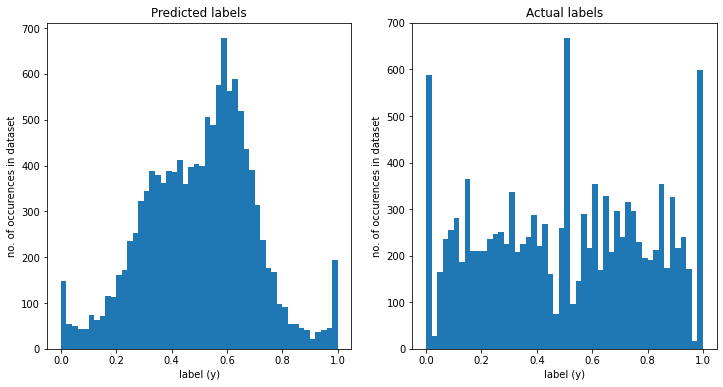

In [ ]:
single_input_testing_data = DataGenerator(data_directory + '/test_set.npz', 'positions', batch_size=1)
single_input_predictions = evaluate_model_and_plot_predictions(single_input_model, single_input_testing_data)

#### For triple input model

Thread 0 completed processing 12500 samples.Model Evaluation:
12500/12500 [==============================] - 26s 2ms/step


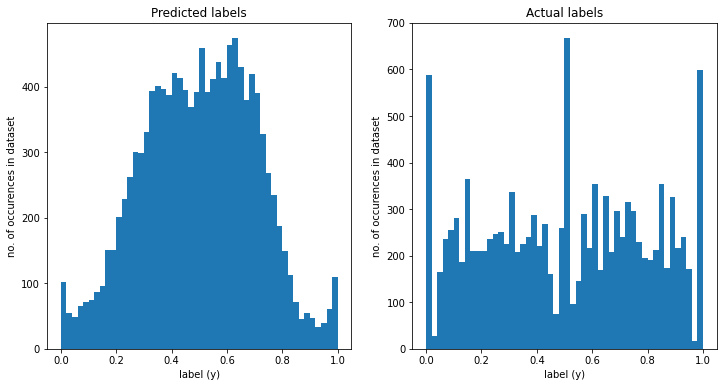

In [ ]:
triple_input_testing_data = DataGenerator(data_directory + '/test_set.npz', 'all', batch_size=1)
triple_input_predictions = evaluate_model_and_plot_predictions(triple_input_model, triple_input_testing_data)

#### For simple input model

Thread 0 completed processing 12500 samples.Model Evaluation:
12500/12500 [==============================] - 23s 2ms/step


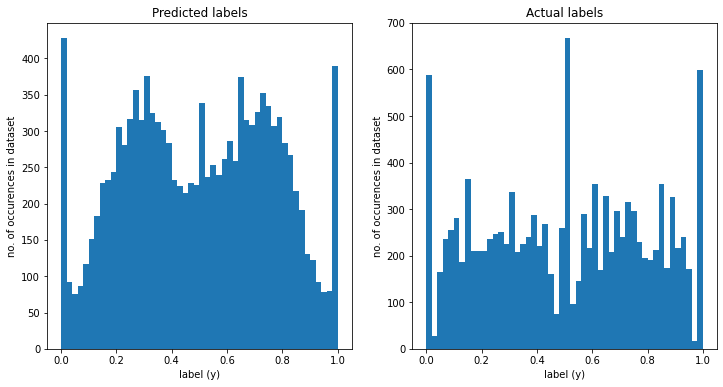

In [ ]:
simple_input_testing_data = DataGenerator(data_directory + '/test_set.npz', 'simple', batch_size=1)
simple_input_predictions = evaluate_model_and_plot_predictions(simple_input_model, simple_input_testing_data)

### Confusion Matrices

NameError: name 'single_input_predictions' is not defined

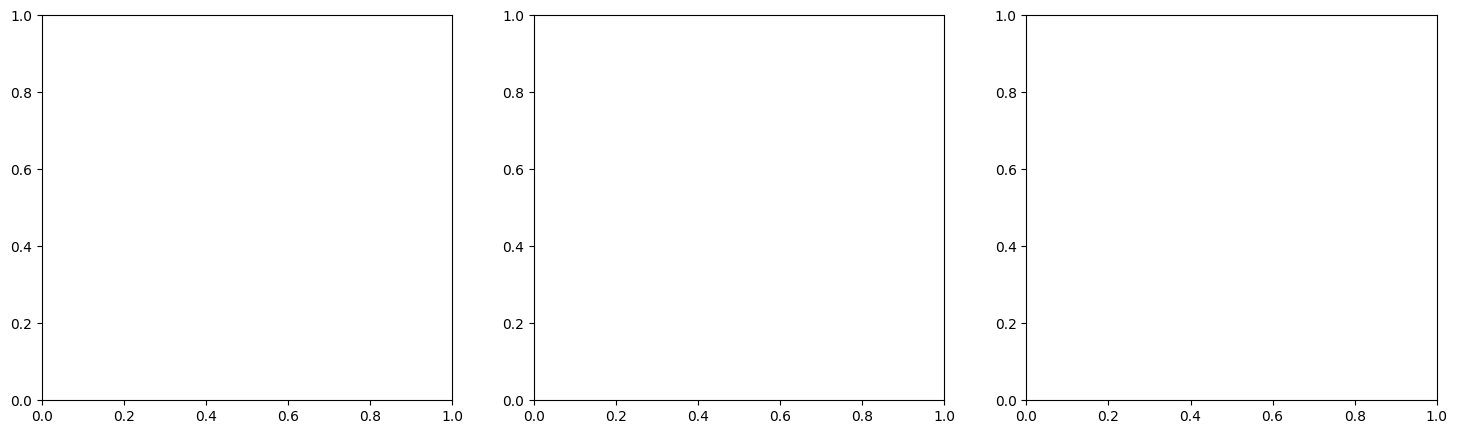

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(predictions, testing_data, ax):
    # Bin the data into continuous intervals, then plot a confusion matrix
    predictions_binned = np.digitize(predictions, bins=np.linspace(0, 1.01, 10))
    y_binned = np.digitize(testing_data.y, bins=np.linspace(0, 1.01, 10))
    cm = confusion_matrix(y_binned, predictions_binned)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plot_confusion_matrix(single_input_predictions, single_input_testing_data, ax[0])
plot_confusion_matrix(triple_input_predictions, triple_input_testing_data, ax[1])
plot_confusion_matrix(simple_input_predictions, simple_input_testing_data, ax[2])

ax[0].set(xlabel='Predicted label', ylabel='True label', title='Single Input Model')
ax[1].set(xlabel='Predicted label', ylabel='True label', title='Triple Input Model')
ax[2].set(xlabel='Predicted label', ylabel='True label', title='Simple Input Model')

plt.show()